# Лабораторная работа №4

In [1]:
import torch
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

print(torch.cuda.is_available())
device = torch.device("cuda")
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
GeForce GTX 1050 Ti


In [2]:
def make_loaders(dataset, train_size):
    train_size = int(train_size * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader, test_loader

Загружаем данные, разбиваем на обучающую и тестовую выборки.

In [21]:
data_transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Lambda(lambda grays: grays * 255.0)])
dataset = datasets.ImageFolder(root='data/notMNIST', transform=data_transform)

train_loader, test_loader = make_loaders(dataset, 0.8)

print('Train size: ', len(train_loader.sampler))
print('Test size: ', len(test_loader.sampler))

Train size:  14979
Test size:  3745


Воспроизводим рекомендованную модель

In [4]:
class NotMNIST_model(nn.Module):
    def __init__(self):
        super(NotMNIST_model, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, stride=1, padding=1)
        self.pooling1 = nn.MaxPool2d(2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.pooling2 = nn.MaxPool2d(2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.fc1 = nn.Linear(3136, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pooling1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pooling2(x)

        x = self.conv3(x)
        x = F.relu(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        output = F.log_softmax(x, dim=1) # в документации к PyTorch советуется использовать log_softmax
        return output

In [5]:
def train(model, device, train_loader, optimizer, epoch, need_print):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if need_print:
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader, need_print):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    if need_print: 
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return 100. * correct / len(test_loader.dataset)

def run(model, num_epochs=3, lr=0.001, momentum=0.95, need_print=True):
    optimizer=optim.SGD(model.parameters(), lr, momentum)
    accuracy = 0
    for epoch in range(1, num_epochs + 1):
        train(model, device, train_loader, optimizer, epoch, need_print)
        accuracy = test(model, device, test_loader, need_print)
    return accuracy

Запускаем обучение и тестирование данной модели

In [6]:
run(NotMNIST_model().to(device));

Train Epoch: 1 [0/14979 (0%)]	Loss: 17.248543
Train Epoch: 1 [3200/14979 (21%)]	Loss: 0.415947
Train Epoch: 1 [6400/14979 (43%)]	Loss: 0.613947
Train Epoch: 1 [9600/14979 (64%)]	Loss: 0.160576
Train Epoch: 1 [12800/14979 (85%)]	Loss: 0.773306

Test set: Average loss: 0.3898, Accuracy: 3340/3745 (89.186%)

Train Epoch: 2 [0/14979 (0%)]	Loss: 0.171862
Train Epoch: 2 [3200/14979 (21%)]	Loss: 0.099877
Train Epoch: 2 [6400/14979 (43%)]	Loss: 0.401445
Train Epoch: 2 [9600/14979 (64%)]	Loss: 0.077993
Train Epoch: 2 [12800/14979 (85%)]	Loss: 0.723030

Test set: Average loss: 0.3111, Accuracy: 3425/3745 (91.455%)

Train Epoch: 3 [0/14979 (0%)]	Loss: 0.132501
Train Epoch: 3 [3200/14979 (21%)]	Loss: 0.068440
Train Epoch: 3 [6400/14979 (43%)]	Loss: 0.246111
Train Epoch: 3 [9600/14979 (64%)]	Loss: 0.098942
Train Epoch: 3 [12800/14979 (85%)]	Loss: 0.500440

Test set: Average loss: 0.2842, Accuracy: 3442/3745 (91.909%)



Получаем ожидаемый результат. Попробуем улучшить его с помощью batch normalization слоев.

In [7]:
class NotMNIST_model_normalization(nn.Module):
    def __init__(self):
        super(NotMNIST_model_normalization, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, stride=1, padding=1)
        self.batchn1 = nn.BatchNorm2d(16)
        self.pooling1 = nn.MaxPool2d(2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.batchn2 = nn.BatchNorm2d(32)
        self.pooling2 = nn.MaxPool2d(2, stride=2, padding=0)

        self.conv3 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.batchn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(3136, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchn1(x)
        x = F.relu(x)
        x = self.pooling1(x)

        x = self.conv2(x)
        x = self.batchn2(x)
        x = F.relu(x)
        x = self.pooling2(x)

        x = self.conv3(x)
        x = self.batchn3(x)
        x = F.relu(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        output = F.log_softmax(x, dim=1)
        return output


In [8]:
run(NotMNIST_model_normalization().to(device));

Train Epoch: 1 [0/14979 (0%)]	Loss: 2.453179
Train Epoch: 1 [3200/14979 (21%)]	Loss: 0.176899
Train Epoch: 1 [6400/14979 (43%)]	Loss: 0.377921
Train Epoch: 1 [9600/14979 (64%)]	Loss: 0.063480
Train Epoch: 1 [12800/14979 (85%)]	Loss: 0.531538

Test set: Average loss: 0.2658, Accuracy: 3441/3745 (91.883%)

Train Epoch: 2 [0/14979 (0%)]	Loss: 0.100324
Train Epoch: 2 [3200/14979 (21%)]	Loss: 0.079321
Train Epoch: 2 [6400/14979 (43%)]	Loss: 0.194987
Train Epoch: 2 [9600/14979 (64%)]	Loss: 0.034836
Train Epoch: 2 [12800/14979 (85%)]	Loss: 0.388912

Test set: Average loss: 0.2456, Accuracy: 3478/3745 (92.870%)

Train Epoch: 3 [0/14979 (0%)]	Loss: 0.073975
Train Epoch: 3 [3200/14979 (21%)]	Loss: 0.070222
Train Epoch: 3 [6400/14979 (43%)]	Loss: 0.155836
Train Epoch: 3 [9600/14979 (64%)]	Loss: 0.027585
Train Epoch: 3 [12800/14979 (85%)]	Loss: 0.325075

Test set: Average loss: 0.2437, Accuracy: 3474/3745 (92.764%)



Точность не очень сильно, но увеличилась, на второй эпохе она даже была больше, чем на первой, но вряд ли здесь приходится говорить о переобучении, так как количество эпох небольшое. Но такое быстрое получение более высокой точности подтверждает то, что batch normalization слои ускоряют работу сети.

Выведем результат воздействия первого сверточного слоя на входное изображение.

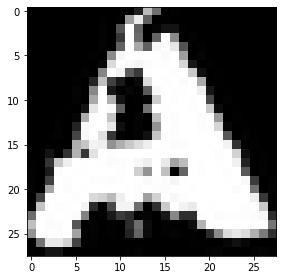

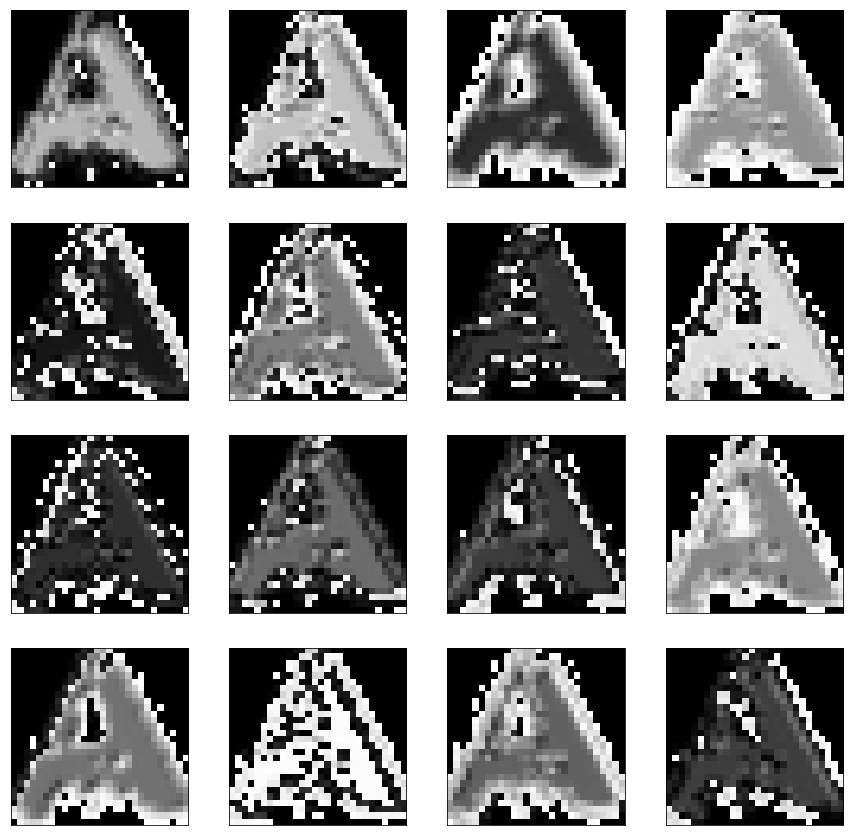

In [23]:
from scipy import ndimage
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import numpy as np

images, _ = next(iter(test_loader))
tensor = images[0].unsqueeze(0).to(device)

conv_ans = NotMNIST_model_normalization().to(device).conv1(tensor).data.to('cpu')
conv_resp = conv_ans.detach().numpy().astype(np.uint8).reshape((16, 28, 28))

image = tensor.to('cpu').reshape((28, 28)).numpy().astype(np.uint8)
imshow(image, cmap=plt.cm.gray)

fig, axes = plt.subplots(4, 4)
fig.set_figheight(15)
fig.set_figwidth(15)
for response, ax in zip(conv_resp, axes.ravel()):
    ax.matshow(response, cmap=plt.cm.gray)
    ax.set_xticks(())
    ax.set_yticks(())

Видим различные варианты выделения признаков.

Загружам данные датасета PetImages

In [10]:
data_transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.ImageFolder(root='data/PetImages', transform=data_transform)

train_loader, test_loader = make_loaders(dataset, 0.8)

print('Train size: ', len(train_loader.sampler))
print('Test size: ', len(test_loader.sampler))

Train size:  19995
Test size:  4999


Создаем и проверяем предлооженную модель.

In [11]:
class PetImages_model(nn.Module):
    def __init__(self):
        super(PetImages_model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=1, padding=1)
        self.pooling1 = nn.MaxPool2d(2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
        self.pooling2 = nn.MaxPool2d(2, stride=2, padding=0)

        self.conv3 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.pooling3 = nn.MaxPool2d(2, stride=2, padding=0)

        self.fc1 = nn.Linear(40000, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pooling1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pooling2(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.pooling3(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


In [12]:
run(PetImages_model().to(device), 10);

Train Epoch: 1 [0/19995 (0%)]	Loss: 0.696765
Train Epoch: 1 [3200/19995 (16%)]	Loss: 0.691353
Train Epoch: 1 [6400/19995 (32%)]	Loss: 0.690371
Train Epoch: 1 [9600/19995 (48%)]	Loss: 0.675878
Train Epoch: 1 [12800/19995 (64%)]	Loss: 0.674493
Train Epoch: 1 [16000/19995 (80%)]	Loss: 0.695837
Train Epoch: 1 [19200/19995 (96%)]	Loss: 0.701737

Test set: Average loss: 0.6800, Accuracy: 2892/4999 (57.852%)

Train Epoch: 2 [0/19995 (0%)]	Loss: 0.703493
Train Epoch: 2 [3200/19995 (16%)]	Loss: 0.698405
Train Epoch: 2 [6400/19995 (32%)]	Loss: 0.681726
Train Epoch: 2 [9600/19995 (48%)]	Loss: 0.595586
Train Epoch: 2 [12800/19995 (64%)]	Loss: 0.636702
Train Epoch: 2 [16000/19995 (80%)]	Loss: 0.695955
Train Epoch: 2 [19200/19995 (96%)]	Loss: 0.679622

Test set: Average loss: 0.6606, Accuracy: 2978/4999 (59.572%)

Train Epoch: 3 [0/19995 (0%)]	Loss: 0.688293
Train Epoch: 3 [3200/19995 (16%)]	Loss: 0.633147
Train Epoch: 3 [6400/19995 (32%)]	Loss: 0.641005
Train Epoch: 3 [9600/19995 (48%)]	Loss: 0.549

Попробуем улучшить результат с помощью batch normalization слоёв.

In [13]:
class PetImages_model_normalization(nn.Module):
    def __init__(self):
        super(PetImages_model_normalization, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pooling1 = nn.MaxPool2d(2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pooling2 = nn.MaxPool2d(2, stride=2, padding=0)

        self.conv3 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pooling3 = nn.MaxPool2d(2, stride=2, padding=0)

        self.fc1 = nn.Linear(40000, 128)
        self.bnfc1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pooling1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pooling2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pooling3(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bnfc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [14]:
run(PetImages_model_normalization().to(device), 10);

Train Epoch: 1 [0/19995 (0%)]	Loss: 0.671510
Train Epoch: 1 [3200/19995 (16%)]	Loss: 0.583907
Train Epoch: 1 [6400/19995 (32%)]	Loss: 0.505105
Train Epoch: 1 [9600/19995 (48%)]	Loss: 0.385065
Train Epoch: 1 [12800/19995 (64%)]	Loss: 0.535475
Train Epoch: 1 [16000/19995 (80%)]	Loss: 0.494559
Train Epoch: 1 [19200/19995 (96%)]	Loss: 0.495638

Test set: Average loss: 0.5043, Accuracy: 3751/4999 (75.035%)

Train Epoch: 2 [0/19995 (0%)]	Loss: 0.371022
Train Epoch: 2 [3200/19995 (16%)]	Loss: 0.503143
Train Epoch: 2 [6400/19995 (32%)]	Loss: 0.431577
Train Epoch: 2 [9600/19995 (48%)]	Loss: 0.242436
Train Epoch: 2 [12800/19995 (64%)]	Loss: 0.393312
Train Epoch: 2 [16000/19995 (80%)]	Loss: 0.464875
Train Epoch: 2 [19200/19995 (96%)]	Loss: 0.380311

Test set: Average loss: 0.4711, Accuracy: 3881/4999 (77.636%)

Train Epoch: 3 [0/19995 (0%)]	Loss: 0.339972
Train Epoch: 3 [3200/19995 (16%)]	Loss: 0.299015
Train Epoch: 3 [6400/19995 (32%)]	Loss: 0.313510
Train Epoch: 3 [9600/19995 (48%)]	Loss: 0.150

In [ ]:
Batch normalization слои позволили достаточно неплохо увеличить точность.

Попробуем добавить dropout слой

In [15]:
class PetImages_model_dropout(nn.Module):
    def __init__(self, p=0.5):
        super(PetImages_model_dropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pooling1 = nn.MaxPool2d(2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pooling2 = nn.MaxPool2d(2, stride=2, padding=0)

        self.conv3 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pooling3 = nn.MaxPool2d(2, stride=2, padding=0)

        self.fc1 = nn.Linear(40000, 128)
        self.bnfc1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(p)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pooling1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pooling2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pooling3(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bnfc1(x)
        x = self.dropout1(x)
        x = F.relu(x)

        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output        

Запускаем на различных параметрах слоя

In [16]:
for p in np.arange(0.0, 0.6, 0.1):
    accuracy = run(PetImages_model_dropout(p).to(device), need_print=False)
    print('\n p = {}, Accuracy: {:.3f}%\n'.format(p, accuracy))


 p = 0.0, Accuracy: 75.795%


 p = 0.1, Accuracy: 75.535%


 p = 0.2, Accuracy: 77.155%


 p = 0.30000000000000004, Accuracy: 77.996%


 p = 0.4, Accuracy: 78.296%


 p = 0.5, Accuracy: 78.076%



Как видим, dropout слой не позволил получить большую точность. Возможно, это связано с тем, что обучение производится не так долго и сеть не успевает переобучиться, с чем, как раз, призван бороться dropout слой.